In [2]:
import requests
import json
import os

# 気象庁データの取得
# jma_url = "https://www.jma.go.jp/bosai/forecast/data/forecast/130000.json"
jma_url = "https://weather.tsukumijima.net/api/forecast/city/130010"
jma_json = requests.get(jma_url).json()

# 取得したいデータを選ぶ
# jma_date = jma_json[0]["timeSeries"][0]["timeDefines"][0]
# jma_weather = jma_json[0]["timeSeries"][0]["areas"][0]["weathers"][0]
# jma_rainfall = jma_json["Feature"][0]["Property"]["WeatherList"]["Weather"][0]["Rainfall"]
# # 全角スペースの削除
# jma_weather = jma_weather.replace('　', '')

# print(jma_date)
# print(jma_weather)
# print(jma_rainfall)

In [3]:
jma_json

{'publicTime': '2025-05-12T17:00:00+09:00',
 'publicTimeFormatted': '2025/05/12 17:00:00',
 'publishingOffice': '気象庁',
 'title': '東京都 東京 の天気',
 'link': 'https://www.jma.go.jp/bosai/forecast/#area_type=offices&area_code=130000',
 'description': {'publicTime': '2025-05-12T16:34:00+09:00',
  'publicTimeFormatted': '2025/05/12 16:34:00',
  'headlineText': '',
  'bodyText': '\u3000前線が、沖縄の南から日本の南を通り、日本の東へのびています。また、関東甲信地方は気圧の谷となっています。\n\n\u3000東京地方は、曇りで雨の降っている所があります。\n\n\u3000１２日は、高気圧に緩やかに覆われますが、前線や気圧の谷の影響を受ける見込みです。このため、曇りで、雨の降る所があるでしょう。\n\n\u3000１３日は、高気圧に覆われますが、湿った空気の影響を受ける見込みです。このため、晴れ朝晩曇りとなるでしょう。\n\n【関東甲信地方】\n\u3000関東甲信地方は、曇りや晴れで、雨の降っている所があります。\n\n\u3000１２日は、高気圧に緩やかに覆われますが、前線や気圧の谷の影響を受ける見込みです。このため、曇りや晴れで、雨や雷雨となる所があるでしょう。\n\n\u3000１３日は、高気圧に覆われますが、湿った空気の影響を受ける見込みです。このため、晴れや曇りとなるでしょう。\n\n\u3000関東地方と伊豆諸島の海上では、１２日から１３日にかけて波がやや高いでしょう。',
  'text': '\u3000前線が、沖縄の南から日本の南を通り、日本の東へのびています。また、関東甲信地方は気圧の谷となっています。\n\n\u3000東京地方は、曇りで雨の降っている所があります。\n\n\u3000１２日は、高気圧に緩やかに覆われますが、前線や気圧の谷の影響を受ける見込みです。このため、曇りで、

In [4]:
import pandas as pd

weather_df = pd.read_csv("../../data/weather_data.csv", encoding="shift-jis", skiprows=[0,1,2,4,5])

In [5]:

weather_df = weather_df[["年月日", "最高気温(℃)", "最低気温(℃)", "天気概況(昼：06時〜18時)"]]
weather_df = weather_df.rename(columns={
    "年月日": "date",
    "最高気温(℃)": "max_temp",
    "最低気温(℃)": "min_temp",
    "天気概況(昼：06時〜18時)": "weather",
})

In [6]:
weather_df["date"] = pd.to_datetime(weather_df["date"], format="%Y/%m/%d")

In [7]:
import  zipfile
import os

In [8]:
zip_dir = os.path.expanduser('../../data/power_usage')
result = []

In [9]:
for zip_name in sorted(os.listdir(zip_dir)):
    if not zip_name.endswith('.zip'):
        continue
    
    zip_path = os.path.join(zip_dir, zip_name)
    
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        for csv_filename in zip_ref.namelist():
            
            if not csv_filename.endswith('.csv'):
                continue
            
            with zip_ref.open(csv_filename) as csv_file:
                try:
                    df = pd.read_csv(csv_file, encoding="shift-jis", skiprows=54)
                    max_power = df["当日実績(５分間隔値)(万kW)"].max()
                    result.append({
                        "date": csv_filename.split('_')[0],
                        "max_power": max_power
                    })
                except Exception as e:
                    print(f"Error reading {csv_filename}: {e}")
                    

In [10]:
power_usage_df = pd.DataFrame(result)
power_usage_df["date"] = pd.to_datetime(power_usage_df["date"], format="%Y%m%d")

In [11]:
integrated_df = pd.merge(weather_df, power_usage_df, on="date", how="inner")

In [12]:
integrated_df

,date,max_temp,min_temp,weather,max_power
0,2022-04-01,12.4,3.9,曇一時雨,3877
1,2022-04-02,12.9,3.6,薄曇時々晴,3351
2,2022-04-03,10.1,6.6,雨一時曇,3546
3,2022-04-04,9.8,6.7,大雨,4185
4,2022-04-05,17.9,8.2,曇一時雨後晴,3663
...,...,...,...,...,...
1001,2024-12-27,12.7,3.8,晴後一時曇,3789
1002,2024-12-28,11.5,1.4,晴後一時曇,3622
1003,2024-12-29,12.3,0.5,快晴,3476
1004,2024-12-30,10.3,3.5,薄曇一時晴,3466


In [13]:
integrated_df["weather"].unique()

array(['曇一時雨', '薄曇時々晴', '雨一時曇', '大雨', '曇一時雨後晴', '曇後晴', '曇', '快晴', '薄曇',
       '雨', '曇時々晴一時雨', '曇時々雨', '曇時々晴', '晴時々曇', '曇後雨', '晴', '曇一時晴',
       '曇時々雨後一時晴', '薄曇一時晴', '薄曇後一時晴', '雨後薄曇', '雨時々曇', '晴後薄曇', '曇時々大雨',
       '晴一時曇', '大雨後曇', '晴後一時曇', '薄曇後時々雨、雷を伴う', '晴一時薄曇', '曇時々雨後晴', '曇後時々雨',
       '雨時々曇一時霧雨', '曇後一時晴', '薄曇後一時雨', '晴時々薄曇', '薄曇後晴', '曇後時々晴', '大雨時々曇',
       '雨時々霧雨一時曇', '曇時々晴一時雨、雷を伴う', '曇時々雨、雷を伴う', '曇時々雨一時晴', '雨一時曇、雷を伴う',
       '雨時々曇一時晴', '雨後晴一時曇', '曇後一時雨', '曇時々雨一時晴、雷を伴う', '大雨時々曇、雷を伴う', '晴後曇',
       '雨後一時曇', '晴後時々薄曇', '晴後時々曇', '薄曇時々雨一時晴', '晴時々曇一時雨', '雨後一時晴',
       '雨時々曇後晴', '雨後曇', '晴一時雨', '雨後晴時々曇', '薄曇時々雨後一時晴', '晴後一時薄曇',
       '雪一時みぞれ後雨', '晴後一時雨', '雨後時々曇', '雨後曇時々晴', '晴後雨時々曇',
       '曇時々晴一時雨、雷・ひょうを伴う', '晴後雨時々曇、雷を伴う', '曇一時雨後時々晴', '曇一時雨後一時晴',
       '薄曇時々晴一時雨', '曇一時晴後一時雨', '曇後時々雨、雷を伴う', '晴後時々曇一時雨', '晴時々雨一時曇、雷を伴う',
       '曇一時晴後雨、雷を伴う', '曇後一時雨、雷を伴う', '霧雨後曇一時雨', '大雨後時々曇一時晴', '曇後時々晴一時雨',
       '晴時々雨一時曇', '雨後曇一時晴', '晴時々薄曇一時雨', '晴時々曇一時雪、雷を伴う', '雨後時々曇一時晴',
       '曇後雪時々雨一時みぞれ', '薄曇後時々

In [14]:
def weather_check(weather: str) -> str:
    """天気の文字列を基本的なカテゴリに分類する関数
    
    Args:
        weather: 元の天気の説明文字列
        
    Returns:
        str: 分類された天気カテゴリ
            快晴、晴れ、晴れ時々曇り、晴れ時々雨、曇り、曇り時々雨、雨、
            雷雨、晴れ（雷あり）、曇り（雷あり）、雷、霧・もや、その他、不明 (NaN値の場合)
    """
    if pd.isna(weather):
        return "不明"
    
    # 雪系
    elif any(keyword in weather for keyword in ["雪", "ゆき"]):
        return "雪"
    
    # 雷系
    if "雷" in weather:
        if any(keyword in weather for keyword in ["雨", "あめ"]):
            return "雷雨"
        elif any(keyword in weather for keyword in ["晴", "日射"]):
            return "晴れ(雷あり)"
        elif any(keyword in weather for keyword in ["曇", "くもり"]):
            return "曇り(雷あり)"
        else:
            return "雷"
    
    # 晴れ系
    if "快晴" in weather:
        return "快晴"
    elif any(keyword in weather for keyword in ["晴", "日射"]):
        if any(keyword in weather for keyword in ["曇", "くもり"]):
            return "晴れ時々曇り"
        elif any(keyword in weather for keyword in ["雨", "あめ", "雷"]):
            return "晴れ時々雨"
        else:
            return "晴れ"
    
    # 曇り系
    elif any(keyword in weather for keyword in ["曇", "くもり"]):
        if any(keyword in weather for keyword in ["雨", "あめ"]):
            return "曇り時々雨"
        else:
            return "曇り"
    
    # 雨系
    elif any(keyword in weather for keyword in ["雨", "あめ"]):
        return "雨"
    
    # その他
    else:
        return "その他"

integrated_df["weather_category"] = integrated_df["weather"].apply(weather_check)
integrated_df = integrated_df.drop(columns=["weather"])

In [15]:
integrated_df["weather_category"].value_counts()

weather_category
晴れ時々曇り     407
曇り時々雨      175
快晴         126
曇り         120
晴れ         112
雨           29
雷雨          22
晴れ時々雨        8
雪            5
晴れ(雷あり)      2
Name: count, dtype: int64

In [16]:
integrated_df

,date,max_temp,min_temp,max_power,weather_category
0,2022-04-01,12.4,3.9,3877,曇り時々雨
1,2022-04-02,12.9,3.6,3351,晴れ時々曇り
2,2022-04-03,10.1,6.6,3546,曇り時々雨
3,2022-04-04,9.8,6.7,4185,雨
4,2022-04-05,17.9,8.2,3663,晴れ時々曇り
...,...,...,...,...,...
1001,2024-12-27,12.7,3.8,3789,晴れ時々曇り
1002,2024-12-28,11.5,1.4,3622,晴れ時々曇り
1003,2024-12-29,12.3,0.5,3476,快晴
1004,2024-12-30,10.3,3.5,3466,晴れ時々曇り


In [17]:
import datetime
import holidays
import numpy as np

JP_HOLIDAY = holidays.Japan()

In [18]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    """データフレーム全体に対して特徴量を作成する関数
    
    Args:
        df: pd.DataFrame（date, max_temp, min_temp, weather_category列を含む）
        
    Returns:
        pd.DataFrame: 特徴量を追加したデータフレーム
    """
    result_df = df.copy()
    
    # 数値系特徴量
    result_df["avg"] = (df["max_temp"] + df["min_temp"]) / 2
    result_df["rng"] = df["max_temp"] - df["min_temp"]
    result_df["cdd"] = (result_df["avg"] - 18).clip(lower=0)
    result_df["hdd"] = (18 - result_df["avg"]).clip(lower=0)
    result_df["hot"] = (df["max_temp"] >= 30).astype(int)
    result_df["cold"] = (df["min_temp"] <= 5).astype(int)
    
    # カレンダー系特徴量
    result_df["year"] = df["date"].dt.year
    result_df["month"] = df["date"].dt.month
    result_df["day"] = df["date"].dt.day
    result_df["dow"] = df["date"].dt.weekday
    result_df["dow_sin"] = np.sin(2 * np.pi * result_df["dow"] / 7)
    result_df["dow_cos"] = np.cos(2 * np.pi * result_df["dow"] / 7)
    result_df["mon_sin"] = np.sin(2 * np.pi * result_df["month"] / 12)
    result_df["mon_cos"] = np.cos(2 * np.pi * result_df["month"] / 12)
    # 休日フラグ
    result_df["weekend"] = (result_df["dow"] >= 5).astype(int)
    # 祝日フラグ
    result_df["holiday"] = result_df["date"].apply(lambda x: int(x in JP_HOLIDAY))
    
    return result_df

In [20]:
from feature_encoder import FeatureEncoder
from omegaconf import OmegaConf, DictConfig
from typing import Dict

In [21]:
df = make_features(integrated_df)

In [22]:
encoders_dict = {}


In [23]:
config_path = 'config.yaml'
config = OmegaConf.load(config_path)
print("Config keys:", config.keys())
print("Encoders config:", config.get("encoders", "Not found"))

Config keys: dict_keys(['encoders'])
Encoders config: [{'name': 'One-Hot', 'columns': ['weather_category']}]


In [24]:
def encode_features(df: pd.DataFrame, config: DictConfig, encoders_dict: Dict[str, FeatureEncoder]):
    """特徴量をエンコードする関数
    
    Args: Dictconfig
        config: 設定ファイルの内容
        encoders_dict: エンコーダー辞書
        df: pd.DataFrame（特徴量を含む）
        
    Returns:
        pd.DataFrame: エンコードされたデータフレーム
    """
    if "encoders" in config:
        for params in config["encoders"]:
            if params["name"] not in encoders_dict:
                encoder = FeatureEncoder(**params)
                df = encoder.fit_transform(df)
                encoders_dict[params["name"]] = encoder
            else:
                encoder = encoders_dict[params["name"]]
                df = encoder.transform(df)
    return df, encoders_dict


In [25]:
df, encoders_dict = encode_features(df, config, encoders_dict)

In [26]:
df

,date,max_temp,min_temp,max_power,weather_category_曇り時々雨,weather_category_晴れ時々曇り,weather_category_雨,weather_category_曇り,weather_category_快晴,weather_category_晴れ,...,year,month,day,dow,dow_sin,dow_cos,mon_sin,mon_cos,weekend,holiday
0,2022-04-01,12.4,3.9,3877,1,0,0,0,0,0,...,2022,4,1,4,-0.433884,-0.900969,8.660254e-01,-0.5,0,0
1,2022-04-02,12.9,3.6,3351,0,1,0,0,0,0,...,2022,4,2,5,-0.974928,-0.222521,8.660254e-01,-0.5,1,0
2,2022-04-03,10.1,6.6,3546,1,0,0,0,0,0,...,2022,4,3,6,-0.781831,0.623490,8.660254e-01,-0.5,1,0
3,2022-04-04,9.8,6.7,4185,0,0,1,0,0,0,...,2022,4,4,0,0.000000,1.000000,8.660254e-01,-0.5,0,0
4,2022-04-05,17.9,8.2,3663,0,1,0,0,0,0,...,2022,4,5,1,0.781831,0.623490,8.660254e-01,-0.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,2024-12-27,12.7,3.8,3789,0,1,0,0,0,0,...,2024,12,27,4,-0.433884,-0.900969,-2.449294e-16,1.0,0,0
1002,2024-12-28,11.5,1.4,3622,0,1,0,0,0,0,...,2024,12,28,5,-0.974928,-0.222521,-2.449294e-16,1.0,1,0
1003,2024-12-29,12.3,0.5,3476,0,0,0,0,1,0,...,2024,12,29,6,-0.781831,0.623490,-2.449294e-16,1.0,1,0
1004,2024-12-30,10.3,3.5,3466,0,1,0,0,0,0,...,2024,12,30,0,0.000000,1.000000,-2.449294e-16,1.0,0,0


In [27]:
import lightgbm as lgb

In [28]:
model = lgb.LGBMRegressor()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      1006 non-null   datetime64[ns]
 1   max_temp                  1006 non-null   float64       
 2   min_temp                  1006 non-null   float64       
 3   max_power                 1006 non-null   int64         
 4   weather_category_曇り時々雨    1006 non-null   int64         
 5   weather_category_晴れ時々曇り   1006 non-null   int64         
 6   weather_category_雨        1006 non-null   int64         
 7   weather_category_曇り       1006 non-null   int64         
 8   weather_category_快晴       1006 non-null   int64         
 9   weather_category_晴れ       1006 non-null   int64         
 10  weather_category_雷雨       1006 non-null   int64         
 11  weather_category_晴れ時々雨    1006 non-null   int64         
 12  weather_category_雪  

In [30]:
df_train = df[df["date"] < "2024-10-01"]
df_test = df[df["date"] >= "2024-10-01"]

In [ ]:
X_train = df_train.drop(columns = ["max_power", "date"])
y_train = df_train["max_power"]
X_test = df_test.drop(columns = ["max_power", "date"])
y_test = df_test["max_power"]

In [ ]:
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1239
[LightGBM] [Info] Number of data points in the train set: 914, number of used features: 25
[LightGBM] [Info] Start training from score 3839.583151


LGBMRegressor()

In [ ]:
model.predict(X_test)

array([3688.66458483, 4551.9484418 , 3825.48273066, 4218.17784493,
       2884.87797713, 2776.17156203, 4120.96784481, 3474.37368618,
       3368.43575344, 3298.84316758, 3272.8757053 , 2918.34030708,
       2882.04156142, 3075.81982203, 3540.86501773, 3613.64607593,
       3762.74534977, 3493.04390572, 3483.82926703, 2822.21195322,
       3299.09879798, 3304.21570764, 3480.78127131, 3737.96429641,
       3451.20323068, 2841.25338363, 2774.47475992, 3307.40446216,
       3308.82097351, 3299.74745986, 3326.69531642, 3277.31202226,
       2973.67850266, 2698.14135411, 2955.31664659, 3363.00656638,
       3515.39579719, 3440.73687375, 3588.8054022 , 3129.0225259 ,
       2987.93047087, 3316.82509074, 3327.78223556, 3343.21145064,
       3394.1053704 , 3366.65110125, 2974.16494737, 2913.81580837,
       3406.41785187, 3871.06650032, 4428.10372305, 3801.36776069,
       3598.56390437, 3080.64817179, 3257.71397536, 3778.20225702,
       3810.21698124, 3439.78930548, 3474.61740413, 3592.50834

In [ ]:
model.feature_name_

['max_temp',
 'min_temp',
 'weather_category_曇り時々雨',
 'weather_category_晴れ時々曇り',
 'weather_category_雨',
 'weather_category_曇り',
 'weather_category_快晴',
 'weather_category_晴れ',
 'weather_category_雷雨',
 'weather_category_晴れ時々雨',
 'weather_category_雪',
 'weather_category_晴れ(雷あり)',
 'avg',
 'rng',
 'cdd',
 'hdd',
 'hot',
 'cold',
 'year',
 'month',
 'day',
 'dow',
 'dow_sin',
 'dow_cos',
 'mon_sin',
 'mon_cos',
 'weekend',
 'holiday']

In [ ]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

In [ ]:
mean_squared_error(y_test, model.predict(X_test))

24405.843763475175

In [ ]:
def plot_feature_importance(
    model_importance: lgb.LGBMModel,
    plot_features: int,
    save_dir: str,
    save_name: str,
) -> None:
    """
    特徴量重要度のプロットを行う
    Args:
        model_importance (AbstractTrainer): 特徴量重要度を取得するモデル
        plot_features (int): 表示する特徴量の数
        save_dir (str): 保存先のディレクトリ
        save_name (str): 保存するファイル名
    """
    df_importance = pd.DataFrame(
        {
            "feature": model_importance.feature_name_,
            "importance": model_importance.feature_importances_,
        }
    )
    df_importance = df_importance.sort_values("importance", ascending=False)
    plt.figure(figsize=(10, plot_features / 2))
    sns.barplot(
        x="importance",
        y="feature",
        data=df_importance.iloc[:plot_features],
    )
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{save_name}.png", format="png")
    df_importance.to_csv(f"{save_dir}/{save_name}.csv", index=False)

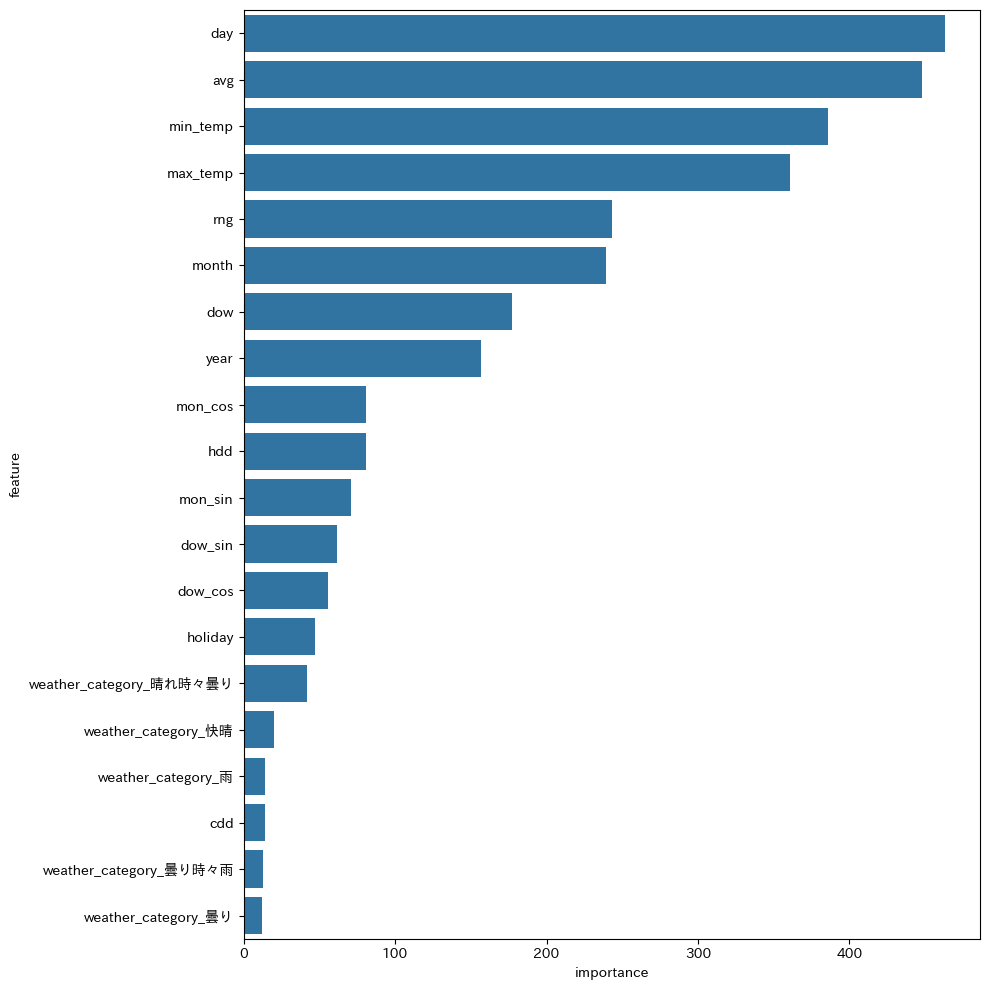

In [ ]:
plot_feature_importance(
    model,
    plot_features=20,
    save_dir="./feature_importance",
    save_name="feature_importance",
)

In [ ]:
from pathlib import Path
import os

output_path = os.getcwd()
test = (Path(output_path) / "evaluation.json")

In [ ]:
test

PosixPath('/Users/ryo/personal_project/power-forecasting-mlops/pipeline/model/evaluation.json')

In [31]:
df = pd.read_csv("~/Desktop/temp.csv")

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   max_temp                  914 non-null    float64
 1   min_temp                  914 non-null    float64
 2   max_power                 914 non-null    int64  
 3   weather_category_曇り時々雨    914 non-null    int64  
 4   weather_category_晴れ時々曇り   914 non-null    int64  
 5   weather_category_雨        914 non-null    int64  
 6   weather_category_曇り       914 non-null    int64  
 7   weather_category_快晴       914 non-null    int64  
 8   weather_category_晴れ       914 non-null    int64  
 9   weather_category_雷雨       914 non-null    int64  
 10  weather_category_晴れ時々雨    914 non-null    int64  
 11  weather_category_雪        914 non-null    int64  
 12  weather_category_晴れ(雷あり)  914 non-null    int64  
 13  avg                       914 non-null    float64
 14  rng       

In [36]:
y = df.pop("max_power")

In [41]:
y.values

array([3877, 3351, 3546, 4185, 3663, 3421, 3436, 3390, 2884, 2870, 3399,
       3436, 3499, 3464, 3656, 3028, 3036, 3527, 3404, 3505, 3405, 3411,
       2960, 2913, 3425, 3448, 3624, 3108, 3087, 2814, 2924, 2920, 2664,
       2662, 2726, 2983, 2818, 2755, 3295, 3316, 3394, 3442, 3440, 3068,
       2899, 3430, 3373, 3459, 3547, 3561, 2938, 2908, 3501, 3606, 3696,
       3671, 3618, 3179, 3121, 3838, 3402, 3658, 3813, 3828, 3078, 2939,
       3473, 3384, 3346, 3482, 3569, 3024, 2945, 3617, 3426, 3417, 3409,
       3716, 3117, 3277, 4303, 4263, 4036, 3894, 4594, 4376, 4129, 5319,
       5263, 5320, 5503, 5570, 4764, 4345, 4435, 4772, 4567, 4565, 4470,
       3853, 3835, 5035, 4417, 4162, 4089, 4062, 3355, 3579, 4189, 4481,
       4974, 4990, 4964, 4504, 4036, 5302, 4589, 5256, 5313, 5356, 4688,
       4691, 5766, 5952, 5938, 4395, 4057, 3470, 3840, 5327, 5568, 5416,
       4580, 4469, 3474, 3823, 4251, 4808, 4525, 4345, 4526, 3992, 3577,
       4438, 5030, 5178, 4261, 4670, 4428, 3205, 38

In [42]:
df2 = pd.read_csv("~/Desktop/temp2.csv")

In [44]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913 entries, 0 to 912
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   3877                 913 non-null    int64  
 1   12.4                 913 non-null    float64
 2   3.9                  913 non-null    float64
 3   1                    913 non-null    int64  
 4   0                    913 non-null    int64  
 5   0.1                  913 non-null    int64  
 6   0.2                  913 non-null    int64  
 7   0.3                  913 non-null    int64  
 8   0.4                  913 non-null    int64  
 9   0.5                  913 non-null    int64  
 10  0.6                  913 non-null    int64  
 11  0.7                  913 non-null    int64  
 12  0.8                  913 non-null    int64  
 13  8.15                 913 non-null    float64
 14  8.5                  913 non-null    float64
 15  0.0                  913 non-null    flo

In [49]:
# object 型かどうかだけでなく「セルの実体」を確認
bad_cols = []
for c in df2.columns:
    if df2[c].apply(lambda v: isinstance(v, list)).any():
        bad_cols.append(c)
print("list が入っている列:", bad_cols)

list が入っている列: []


In [52]:
print(df2.head(1).applymap(type))
for i in range(1, 10):
    print(df2.iloc[i].apply(type))

            3877             12.4              3.9              1  \
0  <class 'int'>  <class 'float'>  <class 'float'>  <class 'int'>   

               0            0.1            0.2            0.3            0.4  \
0  <class 'int'>  <class 'int'>  <class 'int'>  <class 'int'>  <class 'int'>   

             0.5  ...           2022              4            1.2  \
0  <class 'int'>  ...  <class 'int'>  <class 'int'>  <class 'int'>   

             4.1 -0.433883739117558 -0.9009688679024191 0.8660254037844387  \
0  <class 'int'>    <class 'float'>     <class 'float'>    <class 'float'>   

  -0.4999999999999998           0.10           0.11  
0     <class 'float'>  <class 'int'>  <class 'int'>  

[1 rows x 29 columns]
3877                   <class 'float'>
12.4                   <class 'float'>
3.9                    <class 'float'>
1                      <class 'float'>
0                      <class 'float'>
0.1                    <class 'float'>
0.2                    <class 'float'

/var/folders/n_/vlq2xy6x5s7f6hxhg79by8vw0000gn/T/ipykernel_88517/1565484870.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df2.head(1).applymap(type))
